# 1. Install PIP's

In [2]:
%pip install keras

Note: you may need to restart the kernel to use updated packages.


# 2. Import Packages

In [144]:
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
import string
import regex as re
from unidecode import unidecode
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from keras.losses import sparse_categorical_crossentropy
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

# 3. Load Data

In [4]:
df = pd.read_csv("Twitter_Data.csv")
df2 = pd.read_csv("Reddit_Data.csv")
df2 = df2.rename(columns={'clean_comment': 'clean_text'})
df3 = pd.read_csv("twitter_training.csv", names=['id', 'product', 'category', 'clean_text'])
df3 = df3[['clean_text', 'category']]
df4 = pd.read_csv("train.csv", encoding='iso-8859-1')
df4 = df4.rename(columns={'text': 'clean_text', 'sentiment': 'category'})
df4 = df4[['clean_text', 'category']]

In [5]:
df2

,clean_text,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
...,...,...
37244,jesus,0
37245,kya bhai pure saal chutiya banaya modi aur jab...,1
37246,downvote karna tha par upvote hogaya,0
37247,haha nice,1


# 4. Data Wreangling

### 4.1. Standardize Category

In [6]:
df['category'] = df['category'].replace({-1: 0, 0: 1, 1: 2})
df2['category'] = df2['category'].replace({-1: 0, 0: 1, 1: 2})
df3['category'] = df3['category'].replace({"Negative": 0, "Neutral": 1, "Positive": 2})
df4['category'] = df4['category'].replace({"negative": 0, "neutral": 1, "positive": 2})

C:\Users\Victor\AppData\Local\Temp\ipykernel_22220\2629549137.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df4['category'] = df4['category'].replace({"negative": 0, "neutral": 1, "positive": 2})


### 4.2. Concat Dataframe and Drop Duplicate/NA

In [7]:
df = pd.concat([df, df2, df3, df4], ignore_index=True)

In [8]:
df = df.drop_duplicates(subset=['clean_text'])

In [9]:
df = df.dropna(subset=['clean_text'])
df = df.dropna(subset=['category'])

### 4.3. Remove from Category to "Irrelevant"

In [10]:
df = df[df['category'] != 'Irrelevant']
df['category'] = df['category'].astype(int)

In [11]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2
...,...,...
302387,wish we could come see u on Denver husband l...,0
302388,I`ve wondered about rake to. The client has ...,0
302389,Yay good for both of you. Enjoy the break - y...,2
302390,But it was worth it ****.,2


# 5. Data Processing

### 5.1. Conversion Column Message in Lower Case

In [12]:
def to_lower(text):
    return text.lower()

In [13]:
df['clean_text'] = df['clean_text'].apply(to_lower)

In [14]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2
...,...,...
302387,wish we could come see u on denver husband l...,0
302388,i`ve wondered about rake to. the client has ...,0
302389,yay good for both of you. enjoy the break - y...,2
302390,but it was worth it ****.,2


### 5.2. Removing Punctuation, Exemple (".", "!")

In [15]:
def remove_punctuation(text):
    punct = string.punctuation
    punct = punct.replace("'", "")  # Removendo as aspas simples
    punct = punct.replace('"', "")  # Removendo as aspas duplas
    translator = str.maketrans('', '', punct)
    return text.translate(translator)

In [16]:
df['clean_text'] = df['clean_text'].apply(remove_punctuation)

In [17]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2
...,...,...
302387,wish we could come see u on denver husband l...,0
302388,ive wondered about rake to the client has ma...,0
302389,yay good for both of you enjoy the break you...,2
302390,but it was worth it,2


### 5.3. Removing Emoji

In [18]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F300-\U0001F5FF"  # simbol and pictogramas
                               u"\U0001F680-\U0001F6FF"  # transport and ]simbol of map
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [19]:
df['clean_text'] = df['clean_text'].apply(remove_emojis)

In [20]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2
...,...,...
302387,wish we could come see u on denver husband l...,0
302388,ive wondered about rake to the client has ma...,0
302389,yay good for both of you enjoy the break you...,2
302390,but it was worth it,2


### 5.4. Removing Sites and Blogs

In [21]:
def remove_urls(text):
    http = r"http\S+|www\.\S+"
    pattern = re.compile(r"({})".format(http))
    return pattern.sub(r'', text)

In [22]:
df['clean_text'] = df['clean_text'].apply(remove_urls)

In [23]:
df

,clean_text,category
0,when modi promised “minimum government maximum...,0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2
...,...,...
302387,wish we could come see u on denver husband l...,0
302388,ive wondered about rake to the client has ma...,0
302389,yay good for both of you enjoy the break you...,2
302390,but it was worth it,2


### 5.5. Removing Accentuation

In [24]:
def remove_accent(text):
    return unidecode(text)

In [25]:
df['clean_text'] = df['clean_text'].apply(remove_accent)

In [26]:
df

,clean_text,category
0,"when modi promised ""minimum government maximum...",0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2
...,...,...
302387,wish we could come see u on denver husband l...,0
302388,ive wondered about rake to the client has ma...,0
302389,yay good for both of you enjoy the break you...,2
302390,but it was worth it,2


### 5.6. Remove Numbers

In [27]:
def remove_numbers(texto):
    return re.sub(r'\d+', '', texto)

In [28]:
df['clean_text'] = df['clean_text'].apply(remove_numbers)

In [29]:
df

,clean_text,category
0,"when modi promised ""minimum government maximum...",0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2
...,...,...
302387,wish we could come see u on denver husband l...,0
302388,ive wondered about rake to the client has ma...,0
302389,yay good for both of you enjoy the break you...,2
302390,but it was worth it,2


### 5.7. Remove Space Blank Excessive and Remove Broke Line

In [30]:
def remove_broke_line(texto):
    return texto.replace('\n', ' ')

In [31]:
df['clean_text'] = df['clean_text'].apply(remove_broke_line)

In [32]:
df

,clean_text,category
0,"when modi promised ""minimum government maximum...",0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2
...,...,...
302387,wish we could come see u on denver husband l...,0
302388,ive wondered about rake to the client has ma...,0
302389,yay good for both of you enjoy the break you...,2
302390,but it was worth it,2


### 5.8. Remove Blank Space Text

In [33]:
def strip_text(text):
    return text.strip()

In [34]:
df['clean_text'] = df['clean_text'].apply(strip_text)

df

### 5.9. Drop NA

In [35]:
df = df.dropna(subset=['clean_text'])

In [36]:
df

,clean_text,category
0,"when modi promised ""minimum government maximum...",0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2
...,...,...
302387,wish we could come see u on denver husband lo...,0
302388,ive wondered about rake to the client has mad...,0
302389,yay good for both of you enjoy the break you ...,2
302390,but it was worth it,2


# 6. Previus Analyze

In [37]:
def df_metadata(df):
    metadata = pd.DataFrame(df.dtypes, columns=['dtypes'])
    metadata = metadata.reset_index()
    metadata['Column'] = metadata['index']
    metadata = metadata[['Column', 'dtypes']]
    metadata['# Missing'] = df.isnull().sum().values    
    metadata['# Unique'] = df.nunique().values
    
    # Verificar se o DataFrame não está vazio
    if not df.empty:
        metadata['Example'] = df.iloc[0].values
    else:
        metadata['Example'] = None
    
    return metadata

# Aplicar a função ao DataFrame
df_metadata(df)

,Column,dtypes,# Missing,# Unique,Example
0,clean_text,object,0,278736,"when modi promised ""minimum government maximum..."
1,category,int32,0,3,0


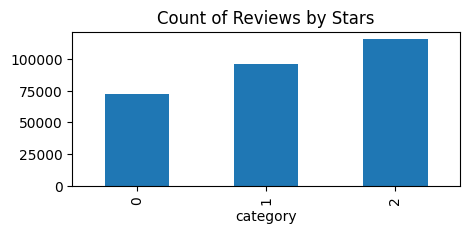

In [38]:
ax = df['category'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(5,2))

In [39]:
example = df['clean_text'].iloc[3]
print(example)

asking his supporters prefix chowkidar their names modi did great service now there confusion what read what not now crustal clear what will crass filthy nonsensical see how most abuses are coming from chowkidars


In [104]:
# Contar o número de cada categoria
counts = df['category'].value_counts()

# Mostrar os resultados
print("Número de ocorrências para cada categoria:")
print("Categoria 0:", counts.get(0, 0))
print("Categoria 1:", counts.get(1, 0))
print("Categoria 2:", counts.get(2, 0))

Número de ocorrências para cada categoria:
Categoria 0: 72691
Categoria 1: 96116
Categoria 2: 115631


In [160]:
# Importe a biblioteca necessária para tokenização
from nltk.tokenize import word_tokenize

# Inicialize um conjunto para armazenar palavras únicas
unique_words = set()

# Itere sobre cada texto em X e adicione suas palavras únicas ao conjunto
for text in df['clean_text']:
    # Tokenize o texto em palavras
    words = word_tokenize(text)
    # Adicione as palavras ao conjunto de palavras únicas
    unique_words.update(words)

# Calcule o número de palavras únicas
num_unique_words = len(unique_words)

print("Número total de palavras únicas em X:", num_unique_words)

Número total de palavras únicas em X: 155944


In [ ]:
# Importe a biblioteca necessária para tokenização
from nltk.tokenize import word_tokenize

# Inicialize a contagem total de palavras
total_words = 0

# Itere sobre cada texto em X e conte o número de palavras em cada texto
for text in df['clean_text']:
    # Tokenize o texto em palavras
    words = word_tokenize(text)
    # Adicione o número de palavras no texto à contagem total de palavras
    total_words += len(words)

print("Número total de palavras em X:", total_words)

# 7. Training Model Sequential with LSTM

### 7.1. Splitting Dataframe into X and Y

In [132]:
X = df['clean_text']
y = df['category']

### 7.2. Split Between Training and Testing

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 7.3. Tokenizer Dataframe X

In [156]:
tokenizer = Tokenizer(num_words=696000)
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

### 7.4. Convert em Pad Sequences

In [157]:
max_length = 100
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

### 7.5. Make Model With LSTM

In [161]:
# Make Model
model = Sequential()

# Corrected Embedding layer
model.add(Embedding(input_dim=155944, output_dim=100))

# Rest of your model architecture (LSTM, Dense layers)
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Compile
model.compile(optimizer='adam', loss=sparse_categorical_crossentropy, metrics=['accuracy'])
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_15 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [163]:
# Definir o EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Treinar o modelo com EarlyStopping e pesos das classes
history = model.fit(train_padded, y_train, epochs=5, batch_size=32, 
                    validation_split=0.1, callbacks=[early_stopping])

Epoch 1/5


6400/6400 ━━━━━━━━━━━━━━━━━━━━ 1144s 179ms/step - accuracy: 0.4181 - loss: 1.0696 - val_accuracy: 0.7987 - val_loss: 0.5227
Epoch 2/5
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 1116s 174ms/step - accuracy: 0.8363 - loss: 0.4579 - val_accuracy: 0.8882 - val_loss: 0.3026
Epoch 3/5
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 1513s 236ms/step - accuracy: 0.9198 - loss: 0.2435 - val_accuracy: 0.9053 - val_loss: 0.2764
Epoch 4/5
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 1472s 230ms/step - accuracy: 0.9511 - loss: 0.1529 - val_accuracy: 0.9065 - val_loss: 0.2780
Epoch 5/5
6400/6400 ━━━━━━━━━━━━━━━━━━━━ 1420s 222ms/step - accuracy: 0.9665 - loss: 0.1046 - val_accuracy: 0.9053 - val_loss: 0.3445
Restoring model weights from the end of the best epoch: 3.


### 7.6. Test Accuracy

In [164]:
# Avaliar o modelo no conjunto de teste
loss, accuracy = model.evaluate(test_padded, y_test)

# Imprimir a acurácia
print("Accuracy:", accuracy)

1778/1778 ━━━━━━━━━━━━━━━━━━━━ 55s 31ms/step - accuracy: 0.9025 - loss: 0.2900
Accuracy: 0.9038988947868347


### 7.7. Saving Models

In [165]:
model.save("kerasmodelLSTM.h5")

### 7.8. Tests Out Dataframe Train/Test

In [1]:
# Frases sobre produtos em inglês
negative_text = "This product is of low quality and does not meet my expectations."
neutral_text = "This product has basic features that meet day-to-day needs."
positive_text = "I am impressed with the quality of this product; it has exceeded my expectations in every aspect."

# Lista de frases
product_texts = [negative_text, neutral_text, positive_text]

# Tokenização das frases
tokenized_texts = tokenizer.texts_to_sequences(product_texts)

# Preenchimento das sequências
padded_texts = pad_sequences(tokenized_texts, maxlen=max_length)

# Prever o sentimento de cada frase
for i, padded_text in enumerate(padded_texts):
    predictions = model.predict(np.array([padded_text]))
    predicted_sentiment = sentiments[np.argmax(predictions)]
    print("Frase:", product_texts[i])
    print("Sentimento Previsto:", predicted_sentiment)
    print()

NameError: name 'tokenizer' is not defined

### 7.9. Confusion Matrix

In [167]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

classes = np.unique(y_test)

# Fazer previsões nos dados de teste
y_pred = model.predict(X_test)
# Obter as classes previstas convertendo as probabilidades em rótulos
y_pred_labels = np.argmax(y_pred, axis=1)

# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Visualizar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

UnimplementedError: Graph execution error:

Detected at node sequential_19_1/Cast defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Victor\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\Victor\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\Victor\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\Victor\AppData\Roaming\Python\Python312\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 638, in run_forever

  File "c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1971, in _run_once

  File "c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 84, in _run

  File "C:\Users\Victor\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\Victor\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\Victor\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\Victor\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\Victor\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\Victor\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\Victor\AppData\Roaming\Python\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\Victor\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\Victor\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\Victor\AppData\Roaming\Python\Python312\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\Victor\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\Victor\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\Victor\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\Victor\AppData\Local\Temp\ipykernel_22220\3004089765.py", line 8, in <module>

  File "c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 515, in predict

  File "c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 213, in one_step_on_data_distributed

  File "c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 202, in one_step_on_data

  File "c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 94, in predict_step

  File "c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py", line 814, in __call__

  File "c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\operation.py", line 48, in __call__

  File "c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\sequential.py", line 202, in call

  File "c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py", line 186, in call

  File "c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py", line 294, in _standardize_inputs

  File "c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py", line 259, in _convert_inputs_to_tensors

  File "c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\core.py", line 495, in convert_to_tensor

  File "c:\Users\Victor\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\core.py", line 121, in convert_to_tensor

Cast string to float is not supported
	 [[{{node sequential_19_1/Cast}}]] [Op:__inference_one_step_on_data_distributed_3064108]

### 7.10. Loss and Accuracy

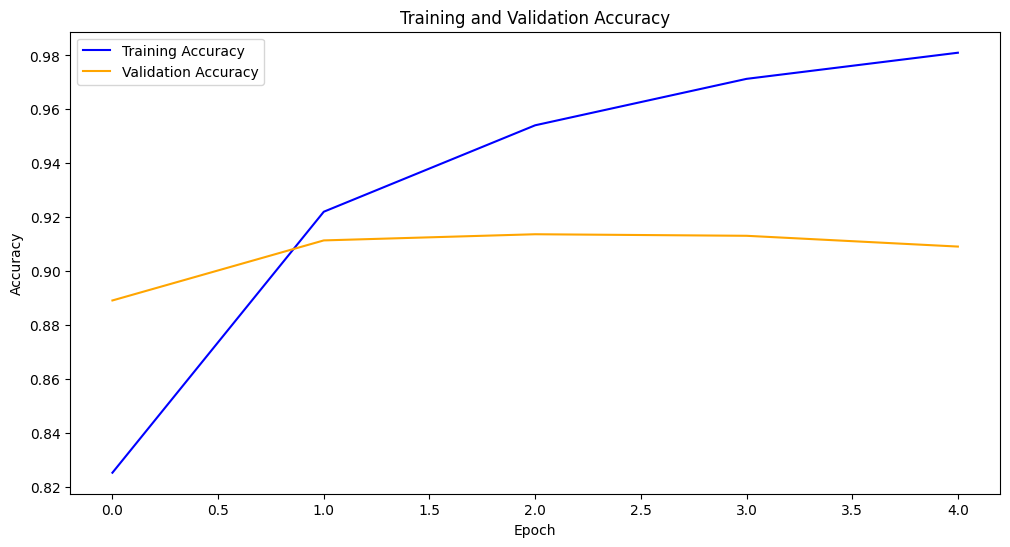

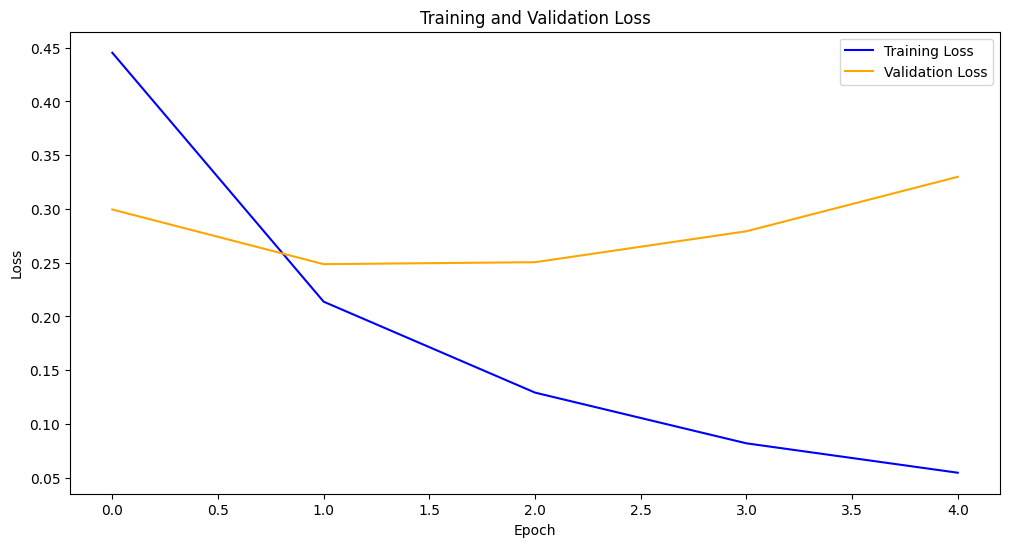

In [118]:
# Extrair acurácia e perda do histórico
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotar acurácia
plt.figure(figsize=(12, 6))
plt.plot(accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotar perda
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()